In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

This notebook is an exploration in strategies for scaling neural nets to _very large_ models across multiple devices. 

We'll start off by looking at the basic types of parallelism, then we might explore a more complex strategy which combines elements of the above, such as deepspeed!  

- Data parallelism
- Model parallelism
- Pipeline parallelism
- Tensor parallelism 

A note on hardware: In this notebook we'll use a TPU because the underlying hardware makes it much, much easier (if your needs scale, you can shift to larger and larger TPU pods without issues with inter-machine communication). Later on, we'll look at the classic approach (kubernetes clusters of individual devices) - but I believe in the long term most large model training will occur on mesh networks of devices (like TPUs, or Tesla's dojo). 

A couple of resources that I've leant on:

- [This excellent series on deep learning hardware](https://blog.inten.to/hardware-for-deep-learning-current-state-and-trends-51c01ebbb6dc)
- [Lilian Weng's superb notes on training large models](https://lilianweng.github.io/lil-log/2021/09/24/train-large-neural-networks.html)
- [Ben Wang's GPT-J - to my knowledge the main published https://github.com/kingoflolz/mesh-transformer-jax



In [1]:
from jax import random
import jax
import jax.numpy as jnp
import jax.profiler
from jax import pmap,value_and_grad
from PIL import Image
import os

# Let jax de-allocate memory when the object is no longer necessary, slows things down - but keeps our memory profiles accurate!
os.environ['XLA_PYTHON_CLIENT_ALLOCATOR']='platform'


In [2]:
# Two helper functions which allow us to visualise memory usage

def show_call_graph():
    !go tool pprof -png memory.prof
    img = Image.open('profile001.png')
    os.remove('profile001.png')
    return img

def show_mem(result):
    result.block_until_ready()
    jax.profiler.save_device_memory_profile("memory.prof")
    !go tool pprof -tags memory.prof

In [3]:
x_devices = 8

batch = 2048
embed = 4096
w_hidden = 8192

keys = random.split(random.PRNGKey(0), x_devices) # [2,x_devices]

# Simple data parallel matrix multiplication

- Lets use pmap to partition across each TPU node - easy!

What are actually doing here? Our input is 8 batch 2048 vectors, each of dimension 4096 - in total we are doing 16384 examples, and multiplying them with a [4096, 8192] 'weights' matrix. 

There is an important distinction to call out here. In the first example, we pmap out and create 8 different weights matrices, so per device memory usage is the same. In the second, we first create a single large weights matrice to be distributed (that is [8, 4096, 8192]), which is implicitly created on jax.devices[0]. This means that the overall memory usage is the same, but most is concentrated on a single device - running a risk of running out of memory. We'll need to keep this in mind when doing model paralleism later - each shard of the model will have to be created separately on each device. If you


In [4]:


def matmult(inp,w1):
    # run a local matmul on each device in parallel (no data transfer)
    result = pmap(jnp.matmul)(inp,w1)
    print(result.shape)
    show_mem(result)

inp = pmap(lambda key: random.normal(key, (batch, embed), dtype=jnp.float32))(keys) # [x_devices, batch, embed]
w1  = pmap(lambda key: random.normal(key, (embed, w_hidden), dtype=jnp.float32))(keys) # [w_hidden, embed]

matmult(inp, w1)


inp = pmap(lambda key: random.normal(key, (batch, embed), dtype=jnp.float32))(keys) # [x_devices, batch, embed]
w1  = random.normal(random.PRNGKey(0), (w_hidden, embed), dtype=jnp.float32) # [w_hidden, embed]
w1_dist = jnp.stack([w1.T] * x_devices) # create a copy to be pmapped across each device

matmult(inp, w1_dist)

del w1_dist # gc this so that it doesn't clog up memory if the cell is re-run

(8, 2048, 8192)
Main binary filename not available.
 device: Total 1.8GB
         224.0MB (12.50%): TPU_0(process=0,(0,0,0,0))
         224.0MB (12.50%): TPU_1(process=0,(0,0,0,1))
         224.0MB (12.50%): TPU_2(process=0,(1,0,0,0))
         224.0MB (12.50%): TPU_3(process=0,(1,0,0,1))
         224.0MB (12.50%): TPU_4(process=0,(0,1,0,0))
         224.0MB (12.50%): TPU_5(process=0,(0,1,0,1))
         224.0MB (12.50%): TPU_6(process=0,(1,1,0,0))
         224.0MB (12.50%): TPU_7(process=0,(1,1,0,1))

 kind: Total 1.8GB
         1.8GB (  100%): buffer
       -9.0B (4.8e-07%): executable

(8, 2048, 8192)
Main binary filename not available.
 device: Total 1.9GB
          1.2GB (65.00%): TPU_0(process=0,(0,0,0,0))
         96.0MB ( 5.00%): TPU_1(process=0,(0,0,0,1))
         96.0MB ( 5.00%): TPU_2(process=0,(1,0,0,0))
         96.0MB ( 5.00%): TPU_3(process=0,(1,0,0,1))
         96.0MB ( 5.00%): TPU_4(process=0,(0,1,0,0))
         96.0MB ( 5.00%): TPU_5(process=0,(0,1,0,1))
         96.0MB

# How do gradients affect memory usage?

- As we can see, taking gradients w.r.t the input matrix effectively doubles memory usage - this makes sense! We're taking gradients w.r.t to both the input and the weight here and need to store them on the device with a 1:1 parameter ratio - so the only thing not doubled is the final output. 

- The gradients will turn out to be extremely important - optimizers like ADAM keep multiple states per paramter for the momentum calculation. Optimising this is one of the critical improvements made by DeepSpeed. 

In [5]:
def matmult_and_grad(inp,w1, devices=8):
    # run a local matmul on each device in parallel (no data transfer)
    def matmul_and_mean(inp, w1):
        result = jnp.mean(jnp.matmul(inp,w1))
        return result
        
    # notice, we take the gradients w.r.t to all of them on a single TPU here. Interesting!
    value, grad = pmap(value_and_grad(matmul_and_mean))(inp, w1)
    
    show_mem(grad)
    
inp = pmap(lambda key: random.normal(key, (batch, embed), dtype=jnp.float32))(keys) # [x_devices, batch, embed]
w1  = pmap(lambda key: random.normal(key, (embed, w_hidden), dtype=jnp.float32))(keys) # [w_hidden, embed]
matmult_and_grad(inp, w1)


 device: Total 1.5GB
         192.0MB (12.50%): TPU_0(process=0,(0,0,0,0))
         192.0MB (12.50%): TPU_1(process=0,(0,0,0,1))
         192.0MB (12.50%): TPU_2(process=0,(1,0,0,0))
         192.0MB (12.50%): TPU_3(process=0,(1,0,0,1))
         192.0MB (12.50%): TPU_4(process=0,(0,1,0,0))
         192.0MB (12.50%): TPU_5(process=0,(0,1,0,1))
         192.0MB (12.50%): TPU_6(process=0,(1,1,0,0))
         192.0MB (12.50%): TPU_7(process=0,(1,1,0,1))

 kind: Total 1.5GB
          1.5GB (  100%): buffer
       -14.0B (8.7e-07%): executable



# Tensor parallelism

What if we have a layer or model that is too big to fit on a single device? 

The great thing about TPUs is that they are a hardware _mesh_ - and when we use xmap we can use named axis to re-arrange these at will to achieve both data and model parallelism.

How does model parallelism work? For starters, lets look at [Megatron LM's method](https://arxiv.org/pdf/1909.08053.pdf), which is what was used for GPT-J. It has a great balance of simplicity and effectiveness, and is very efficient provided you have a hardware mesh. Luckily we do!

- Megatron LM: Takes advantage of the fact that sections of a matrix multiplication and self-attention can be calculated across separate devices with minimal communication. Megatron's approach optimises for minimising communication overheads at the expense of some increase in memory. E.g., the layer norm parameters are duplicated, and take the output of the previous layer. "Since all parameters are either local or duplicated, there is no need for communicating updated parameters."

How does it work in the case of a simple matrix multiplication + nonlinearity?

$$ Y  = GELU(XA) $$ 

If we split A along it's columns A = [A_1, A_2], we can perform the calculation and apply the non-linearity indepedently.

$$ Y  = [Y_1, Y_2] = [GeLU(XA_1), GeLU(XA_2)]$$

In the next section we'll look at how it works with multiple MMs and self-attention, first lets introduce x-map!




In [6]:
from jax.experimental.maps import mesh, xmap
import numpy as np

In [7]:
batch = 16384
embed = 4096
w_hidden = 8192

inp = random.normal(random.PRNGKey(0), (batch, embed), dtype=jnp.float32) # [batch, embed]
w1  = random.normal(random.PRNGKey(0), (w_hidden, embed), dtype=jnp.float32) # [w_hidden, embed]

In [8]:
# reshape our 8 devices into a 2,4 mesh with axis names x,y

x_devices = 4
y_devices = 8//x_devices

axis_names = ('x', 'y')
mesh_devices = np.array(jax.devices()).reshape((x_devices, y_devices))
mesh_def = (mesh_devices, axis_names)

In [9]:
def matmult(x, w1):
    '''
    x: [x_devices: the number of devices we are partitioning across
        batch: ..
        embed: .. ]
    w1: [w_hidden: will be partioned evenly over the columns of the mesh 
         embed: the hidden size, but it is partitioned ... ]
    '''

    res = jnp.matmul(x,w1)
    mean_embed = jnp.sum(res, axis=['batch']) / 8096
    return mean_embed

with mesh(*mesh_def):
    out = xmap(matmult, 
              in_axes = (['batch',  ...], ['w_hidden', ...]),
              out_axes = ['batch', 'w_hidden', ...],
              axis_resources={'batch': 'x', 'w_hidden': 'y'})(inp, w1)
    
    
    show_mem(out)
    print(out.shape)
    

/usr/local/lib/python3.8/dist-packages/jax/experimental/maps.py:418: UserWarning: xmap is an experimental feature and probably has bugs!
  warn("xmap is an experimental feature and probably has bugs!")


Main binary filename not available.
 device: Total 896.0MB
         448.0MB (50.00%): TPU_0(process=0,(0,0,0,0))
          64.0MB ( 7.14%): TPU_1(process=0,(0,0,0,1))
          64.0MB ( 7.14%): TPU_2(process=0,(1,0,0,0))
          64.0MB ( 7.14%): TPU_3(process=0,(1,0,0,1))
          64.0MB ( 7.14%): TPU_4(process=0,(0,1,0,0))
          64.0MB ( 7.14%): TPU_5(process=0,(0,1,0,1))
          64.0MB ( 7.14%): TPU_6(process=0,(1,1,0,0))
          64.0MB ( 7.14%): TPU_7(process=0,(1,1,0,1))

 kind: Total 896.0MB
        896.0MB (  100%): buffer
       -18.0B (1.9e-06%): executable

(16384, 8192)


This is really cool! With x-map, we can just take the same size inputs [16384, 4096] and [4096, 8192], and perform the computation in both a data and batch parallel fashion. The batch axis is split across 4 machines, the weight across 2. Now - the issue is that like the second example these large matrices were created on device 0 and remain there. Lets do this properly this time, and start building the components for a transformer block.  We'll need to init the component of the weights separately across each 'shard'.

# A transformer block

- Ben Wang's GPT-J has an excellent, production ready example. Here, we'll draw from the design choices of both minGPT and GPT-J in an effort to make a minimal, but complete example. The biggest difference you'll notice is the absence of the batch dimension inside the block. When I wrote this initially I did it much closer to the minGPT implementation (e.g. 'bhtT, bThd->bthd'), but if you partition the batch dimension across one of the dimensions in your hardware mesh it gets abstracted away - and so the internal code is very similar to GPT-J. 
- The key fact that we're taking advantage of is that sections of the embedding are allocated to differnet self-attention 'heads' - which means that we can split across shards easily. So long as the # heads is divisible by the number of shards. E.g. if our embedding is 2048, and we have 8 heads of 256 each - we could split the embedding across 2 shards, alllocating 4 heads per shard. 


In [10]:
import haiku as hk

# A simple transformer layer shard that exists on one of the devices. 


GPT1Config = {
    'n_vocab': 5000,
    'block_size': 32,
    'n_layer' : 12,
    'n_head' : 12,
    'd_model' : 768,
    'shards': 2}




class TransformerLayerShard(hk.Module):
        def __init__(self, config, name=None, init_scale=1.):
            super().__init__(name=name)
            heads = config["n_head"]
            dim = config["d_model"]
            self.shards  = config["shards"]
            
            assert dim % heads == 0 
            assert heads % self.shards == 0 
            
            self.dim_per_head = dim // heads
            self.dim_per_shard = dim // self.shards
            self.heads_per_shard = heads // self.shards
#             print(self.dim_per_head, self.dim_per_shard, self.heads_per_shard)
            
            # GPT-J uses a common layer norm between the mlp and the self attention, minGPT uses different - lets go with one for now. Much of a muchness.
            self.ln = hk.LayerNorm(-1, True, True)
            
            # key, query and value projections for all heads on this shard
            self.q = hk.Linear(self.dim_per_shard, with_bias=False)
            self.k = hk.Linear(self.dim_per_shard, with_bias=False)
            self.v = hk.Linear(self.dim_per_shard, with_bias=False)
            
            # self att output projection
            self.att_proj = hk.Linear(dim, with_bias=False, w_init=hk.initializers.TruncatedNormal(stddev=init_scale / np.sqrt(dim)))
            
            self.dense_proj = hk.Linear(self.dim_per_shard * 4)
            self.dense_proj_out = hk.Linear(dim,
                                      w_init=hk.initializers.TruncatedNormal(stddev=init_scale / np.sqrt(dim)))
            
            
        def self_attention(self, q, k ,v, bias):
            '''
            k,q,v: [T, heads_per_shard, dim_per_head]
            '''
            T, _, _ = k.shape
            
            attention_logits = jnp.einsum('thd,Thd->htT', q, k) # [heads_per_shard, T,T]
            sqrt_key_size = np.sqrt(self.dim_per_head).astype(k.dtype) # [1,]
            
            attention_logits = attention_logits/sqrt_key_size # [heads_per_shard, T,T]
            
            attention_logits += bias # [B, heads_per_shard, T,T]
            
            attention_weights = jax.nn.softmax(attention_logits)  # [heads_per_shard, T,T]
            
            weighted_values = jnp.einsum('htT, Thd->thd', attention_weights, v).reshape((T, self.dim_per_shard)) # [T, dim_per_shard]
            
            return self.att_proj(weighted_values)
        
        def feed_forward(self, x):
            '''
            x: [T,embed_dim]
            '''
            dense_proj = self.dense_proj(x)
            dense_proj = jax.nn.gelu(dense_proj)
            return self.dense_proj_out(dense_proj)
            
            
        def qkv_proj(self, x): 
            '''
            x: [T, embed_dim]
            '''
            q = self.q(x).reshape(x.shape[:-1] + (self.heads_per_shard, self.dim_per_head)) # [T, heads_per_shard, dim_per_head]
            v = self.v(x).reshape(x.shape[:-1] + (self.heads_per_shard, self.dim_per_head)) # ""
            k = self.k(x).reshape(x.shape[:-1] + (self.heads_per_shard, self.dim_per_head)) # "" 
            
            return q,k,v
        
        
        def __call__(self, x):
            '''
            x: [T, embed_dim]
            '''
            # preliminaries    
#             print(x.shape)
            T,C = x.shape
            x = self.ln(x) # [T,embed_dim]
            
            # causal self attention
            q,k,v = self.qkv_proj(x)
            causal_mask = np.tril(np.ones((T,T))) # [T,T]
            bias = -1e10 * (1. - causal_mask) # [T,T]
            attn = self.self_attention(q, k ,v, bias)  # [T,embed_dim]
            
            # feedforward
            ff  = self.feed_forward(x) # [B,T,embed_dim]
            
            # block
            x = x + attn # [T,embed_dim]
            x = x + ff # [T,embed_dim]
            
            # We finally need to sum across shards to collect the information from each head into the new embedding 
            # In the full GPT-J implementation, they've defined a custom operator which does the psum on the forward pass but
            # is the identity function on the backward pass - currently testing how necessary that is.
            return jax.lax.psum(x, "shard")

        
                
def model_fn(x):
    model = TransformerLayerShard(GPT1Config)
    return model(x)


In [11]:
# It would be possible to test the above block without xmap if we got rid of the psum - but I'm going to be slightly opinionated here despite the boilerplate setup.


batch = 4
shard = 2

axis_names = ('dp', 'mp')
mesh_devices = np.array(jax.devices()).reshape((batch, shard))
mesh_def = (mesh_devices, axis_names)


init = jax.experimental.maps.xmap(fun=hk.transform(model_fn).init,
                                  in_axes=(["shard", ...],
                                           ["batch", ...]),
                                  out_axes=["shard", ...],
                                  axis_resources={'shard': 'mp', 'batch': 'dp'})

forward = jax.experimental.maps.xmap(fun=hk.without_apply_rng(hk.transform(model_fn)).apply,
                                     in_axes=(["shard", ...],
                                              ["batch", ...]),
                                     out_axes=["batch", ...],
                                     axis_resources={'shard': 'mp', 'batch': 'dp'})

In [12]:
key = hk.PRNGSequence(42)
x = jax.random.uniform(next(key), (16, 32, 768), minval=0, maxval=255).astype(jnp.float32)  # [B,T,embed]

with jax.experimental.maps.mesh(*mesh_def):
    state = init(jnp.array(key.take(shard)), x)

    o = forward(state, x)
    print(o.shape)

(16, 32, 768)


# Creating a transformer

Now all we're missing is an embedding layer to transform a sequence of discrete tokens to a dense vector - and an output projection layer to send it back! 


## Embedding layer
Functionally, this is a sequence of [Batch, Time, Vocab_size] multiplied by a [Vocab_size, embedding_dim] matrix to project the one hot sequence into a dense embedding. 

There are two approaches that could make sense:

1. Partition the embedding matrix along the vocabulary dimension. The implementation of this in GPT-J is cheeky:
    i. Assign a subset of token indices to each shard. E.g. if our vocab dimension is 50k, 0-25k correspond to shard 0, 25k-50k correspond to shard 1.
    ii. In the one-hot expansion of the input sequence, zero anything which lies outside this range. This means that the projection matrix on each shard only needs to be [25k,embedding_dim], but the zero-d tokens will not contribute to the embedding on that shard.
    iii. psum across the shards to get the full embedding. 
    
    
2. Alternatively, partition along the embedding dimension. In this case, the embedding matrix on each shard would be [50k, embedding_dim//shards], every token would be fully expanded into the one-hot representation and an all_gather would be required across the shards to concatenate the embedding dim of the outputs.

In both cases  <b> the embedding weights matrix will be the same size  </b> (it doesn't matter which dimension is divided by shards),  <b> but the methods differ in terms of the space allocated for the input sequence</b>. The second method requires the full input sequence be expanded to the full one-hot representation on each device, but the first method divides the size of that representation by the number of shards - saving more space. 


In [13]:
class EmbeddingShard(hk.Module):
    def __init__(self, config, name=None):
        super().__init__(name=name)
        in_dim = config["n_vocab"]
        out_dim = config["d_model"]
        shards = config["shards"]

        assert in_dim % shards == 0

        self.in_dim = in_dim
        self.out_dim = out_dim
        self.in_dim_per_shard = in_dim // shards
        self.out_dim_per_shard = out_dim // shards

        embed_init = hk.initializers.TruncatedNormal(stddev=0.02)
        self.positional_embeddings = hk.get_parameter('pos_embs', [config["block_size"], self.out_dim_per_shard], init=embed_init)

        # notice unlike the ff transformer layer, this linear layer has the full output dimension because we are partitioning across vocab. 
        self.proj = hk.Linear(self.out_dim, w_init=hk.initializers.TruncatedNormal(stddev=1 / np.sqrt(in_dim)))

    def __call__(self, x, dtype=jnp.bfloat16):
        
        # work out which shard we are on, and the start token index
        shard_start_index = jax.lax.axis_index('shard') * self.in_dim_per_shard
        
        # subtract the shard_start_index from the input indices. This means anything below it will be zero-d (as it will be a negative number)
        # at the same time, anything above 'in_dim_per_shard' will also be zero-d. This means that each shard gets a window of in_dim_per_shard indices
        # which it will expand to a one-hot representation - saving lots of space!
        input_onehot = jax.nn.one_hot(x - shard_start_index, self.in_dim_per_shard)
        proj_out = self.proj(input_onehot)
        # sum across shards to create a full embedding
        proj_out = jax.lax.psum(proj_out, "shard")
        # gets all of the positional embeddings as split across each shard (column wise split of positional embeddings)
        all_pos_embed = jax.lax.all_gather(self.positional_embeddings, 'shard')
        # flattens them, so now there are identical, complete positional embeddings on each device
        all_pos_embed = hk.Flatten()(jnp.transpose(all_pos_embed, (1, 0, 2)))

        proj_out += all_pos_embed[:proj_out.shape[0]] # only do the embeddings up to the length of the input sequence, to allow for variable input size

        return proj_out

## Projection layer

The projection layer is much more similar to the simple matrix multiplication example above. As we'll have the full embedding as an output of transformer layer below we partition across the output dim, then all gather to get the final output embedding in vocab space. 

Where it gets trickier is how this interacts with the loss calculation. The [batch, time, vocab_size] matrix output above is large, and we'd prefer to only generate it when necesary (e.g. during inference). During training, could we calculate the per shard loss components and then only cross-communicate the smaller [batch, time] cross entropy loss values?

Yes! We'll still need some cross communication (e.g. to calculate the max of the logits to stabilise it numerically, or calculate the denominator of the softmax equation), but this comes with no memory penalty!

This is directly lifted from GPT-J, but I'll comment extensively so it is clear what is going on.

The loss function isn't the typical implementation of softmax cross entropy, so lets simplify it down to explain it. The implementation is convenient and stable - minimising communication overheads across shards to a limited set of sums. 




In [105]:
# A test case
logit = jnp.array([[-0.3,1,0.1], [0.1, 2, 0.4]])
target = jnp.array([[1,0,0], [0,0,1]])

def loss(logit, target):
    # numerically stabilise logits
    stable_logit = logit - logit.max(-1, keepdims=True)
    # zero out any entries in the logit which don't correspond to the true label
    predicted_logit = jnp.multiply(target, stable_logit)
    # sum up the logit
    log_sum_exp = jnp.log(jnp.exp(stable_logit).sum(axis=-1))
    # subtract the summed logit from the summed 'predicted_logit'
    # On a per dimension basis, if the maximum value is in the correct entry
    # then the subtraction will = 0. Similarly, any entry but the correct one is 0 in the label.
    # therefore the element wise multiplication of the stable logit with the target which converges because
    # logit is on both the LHS and RHS of the equation. 
    # By only working with sums when we are using the sharded version we minimise communication.
    loss = log_sum_exp - predicted_logit.sum(axis=-1)
    # And it allows for a really elegant way of calculating accuracy!
    return loss.sum()
    

for i in range(0,10):
    print(jnp.multiply(target, logit - logit.max(-1, keepdims=True)))
    l, grad_wrt_logit  =  value_and_grad(loss)(logit, target)
    logit -= 1 * grad_wrt_logit
    print(l)
    

[[-1.3  0.  -0. ]
 [-0.   0.  -1.6]]
3.719463
[[ 0.         -0.         -0.        ]
 [-0.          0.         -0.00945294]]
1.6977012
[[ 0. -0. -0.]
 [-0. -0.  0.]]
0.8638048
[[ 0. -0. -0.]
 [-0. -0.  0.]]
0.5450409
[[ 0. -0. -0.]
 [-0. -0.  0.]]
0.39282578
[[ 0. -0. -0.]
 [-0. -0.  0.]]
0.30563444
[[ 0. -0. -0.]
 [-0. -0.  0.]]
0.24965373
[[ 0. -0. -0.]
 [-0. -0.  0.]]
0.21083269
[[ 0. -0. -0.]
 [-0. -0.  0.]]
0.18234465
[[ 0. -0. -0.]
 [-0. -0.  0.]]
0.16059524


In [124]:

    
class ProjectionShard(hk.Module):
    def __init__(self, config, name=None):
        super().__init__(name=name)
        out_dim = config["n_vocab"]
        shards = config["shards"]

        assert out_dim % shards == 0

        self.dim = out_dim
        self.dim_per_shard = out_dim // shards

        self.norm = hk.LayerNorm(-1, True, True)

        self.proj = hk.Linear(self.dim_per_shard)

    def __call__(self, x):
        x = self.norm(x)
        proj = self.proj(x)

        all_proj = jax.lax.all_gather(proj, 'shard')

        return hk.Flatten()(jnp.transpose(all_proj, (1, 0, 2)))

    def loss(self, x, targets, z_loss=1):
        
        '''
        x: [T, dim_per_shard]
        targets: [T]
        '''
        x = self.norm(x)
        # calculate logits on a per shard basis
        logits = self.proj(x) # [T, dim_per_shard]
        # get the max of logits per dimension across the shards. Use this to prevent both under and overflow by subtracting it from every logit.
        # For an explaination on why you need this - see the opening pages of chapter 4 'Numerical computation' in goodfellow's deep learning book. 
        global_max = jax.lax.pmax(jax.lax.stop_gradient(logits.max(-1, keepdims=True)), "shard")
        logits -= jax.lax.stop_gradient(global_max) # [T, dim_per_shard]
        
        # As we are computing the output vocab matrix in a sharded fashion, only get the targets corresponding to that shard
        # using the same trick as used in the embedding matrix.
        shard_start_index = jax.lax.axis_index('shard') * self.dim_per_shard
        gt_onehot = jax.nn.one_hot(targets - shard_start_index, self.dim_per_shard) # [T, dim_per_shard]
        # this is a point multiplication, so it zeros out anything which isn't a 1 in the one-hot representation. 
        # then sums along the embedding axis. See above code snippet for explaination for the next few lines.
        predicted_logits = jnp.sum(jnp.multiply(gt_onehot, logits), axis=-1) # [T]
        predicted_logits = jax.lax.psum(predicted_logits, 'shard') 
        exp_logits = jnp.exp(logits)
        sum_exp_logits = exp_logits.sum(axis=-1)
        sum_exp_logits = jax.lax.psum(sum_exp_logits, 'shard')

        loss = jnp.log(sum_exp_logits) - predicted_logits
        # An additional loss which keeps the logits small - avoiding roundoff errors in bfloat16 (according to the mesh tensorflow repo).
        loss += (1e-4 * jnp.square(jnp.log(sum_exp_logits)) * z_loss).mean()

        correct = (0.0 == predicted_logits)
        return jax.lax.psum(loss.sum(), 'batch'), correct
    
    


## Sharded transformer

This is easy - just combine the sharded layers as one would a transformer on one device. Saving and loading weights will be a little more complex though :)

In [125]:
class CausalTransformerShard(hk.Module):
    def __init__(self, config):
        super().__init__()
        heads = config["n_head"]
        shards = config["shards"]
        layer_count = config["n_layer"]

        self.layers = []
        self.heads = heads

        self.heads_per_shard = heads // shards

        self.embed = EmbeddingShard(config)

        init_scale = 2. / layer_count

        for i in range(layer_count):
            self.layers.append(TransformerLayerShard(config, name=f"layer_{i}", init_scale=init_scale))

        self.proj = ProjectionShard(config)
        
        
    def trunk(self, tokens):
        x = self.embed(tokens)

        for l in self.layers:
            x = x + l(x)
        return x
    
    def loss(self, tokens, targets):
        x = self.trunk(tokens)
        l, acc = self.proj.loss(x, targets)
        return l

    def __call__(self, tokens):
        
        x = self.trunk(tokens)
        return self.proj(x)
    
    
    
    


In [167]:
import optax

batch = 4
shard = 2

GPT1Config = {
    'n_vocab': 5000,
    'block_size': 32,
    'n_layer' : 2,
    'n_head' : 4,
    'd_model' : 768*4,
    'shards': 2}



axis_names = ('batch', 'shard')
mesh_devices = np.array(jax.devices()).reshape((batch, shard))
mesh_def = (mesh_devices, axis_names)


optimizer = optax.adam(1e-4)

# Haiku pure functions for convenience 
def eval_fn(x):
    model = CausalTransformerShard(GPT1Config)
    return model(x)

def train_fn(x,y):
    model = CausalTransformerShard(GPT1Config)
    return model.loss(x,y)



def init(key, x):
    '''
    A parallelised init function that ensures optimiser params are stored on the respective devices. 
    '''
    params = hk.transform(model_fn).init(key, x)
    
    return {
        "params": params,
        "step": np.array(0),
        "opt_state": optimizer.init(params)
    }

def eval_step(params, x):
    
    forward_fn = hk.without_apply_rng(hk.transform(eval_fn))
    out = forward_fn.apply(params, x)
    return out

def train_step(params, opt_state, x,y):
    
    l_fn = hk.without_apply_rng(hk.transform(train_fn))
    loss, grads = value_and_grad(l_fn.apply)(params, x,y)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return loss#, params, opt_state
    
    
    
init = jax.experimental.maps.xmap(fun=init,
                                  in_axes=(["shard", ...], # rngs
                                           ["batch", ...]), # x
                                  out_axes=["shard", ...],
                                  axis_resources={'shard': 'shard', 'batch': 'batch'})

forward = jax.experimental.maps.xmap(fun=eval_step,
                                     in_axes=(["shard", ...], # params
                                              ["batch", ...]), # x 
                                     out_axes=(["batch", ...]), 
                                     axis_resources={'shard': 'shard', 'batch': 'batch'})




key = hk.PRNGSequence(42)
x = jax.random.uniform(next(key), (16, 32), minval=0, maxval=255).astype(jnp.int32)  # [B,T,embed]

with jax.experimental.maps.mesh(*mesh_def):
    state = init(jnp.array(key.take(shard)), x)

    o = forward(state['params'], x)
    show_mem(o)


 device: Total 43.1GB
         5.7GB (13.26%): TPU_0(process=0,(0,0,0,0))
         5.3GB (12.39%): TPU_1(process=0,(0,0,0,1))
         5.3GB (12.39%): TPU_2(process=0,(1,0,0,0))
         5.3GB (12.39%): TPU_3(process=0,(1,0,0,1))
         5.3GB (12.39%): TPU_4(process=0,(0,1,0,0))
         5.3GB (12.39%): TPU_5(process=0,(0,1,0,1))
         5.3GB (12.39%): TPU_6(process=0,(1,1,0,0))
         5.3GB (12.39%): TPU_7(process=0,(1,1,0,1))

 kind: Total 43.1GB
         43.1GB (  100%): buffer
       -64.0B (1.4e-07%): executable



In [173]:
def train_step(params, opt_state, x,y):
    
    l_fn = hk.without_apply_rng(hk.transform(train_fn))
    loss, grads = value_and_grad(l_fn.apply)(params, x,y)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return loss#, params, opt_state


train = jax.experimental.maps.xmap(fun=train_step,
                                     in_axes=(["shard", ...], # params
                                              ["shard", ...], # opt state
                                              ["batch", ...], # x
                                              ["batch", ...]),# y
                                     out_axes=([]), # opt state
                                     axis_resources={'shard': 'shard', 'batch': 'batch'})


with jax.experimental.maps.mesh(*mesh_def):
    o = train(state['params'], state['opt_state'], x,x)
    print(o)

4574.929


In [138]:
o

ShardedDeviceArray(4574.929, dtype=float32)

In [308]:
!pip install optax

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 126 kB 5.4 MB/s eta 0:00:01
     |████████████████████████████████| 65 kB 5.0 MB/s  eta 0:00:01
     |████████████████████████████████| 55 kB 5.6 MB/s  eta 0:00:01
     |████████████████████████████████| 94 kB 5.0 MB/s  eta 0:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-nightly 2.6.0 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
tf-nightly 2.6.0 requires typing-extensions~=3.7.4, but you have typing-extensions 3.10.0.2 which is incompatible.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [219]:
# Todo

# Take loss w.r.t to label
# load data
# save / restore model
# multi node? 


 device: Total 2.6GB
         668.7MB (25.13%): TPU_0(process=0,(0,0,0,0))
         284.6MB (10.70%): TPU_1(process=0,(0,0,0,1))
         284.6MB (10.70%): TPU_2(process=0,(1,0,0,0))
         284.6MB (10.70%): TPU_3(process=0,(1,0,0,1))
         284.6MB (10.70%): TPU_4(process=0,(0,1,0,0))
         284.6MB (10.70%): TPU_5(process=0,(0,1,0,1))
         284.6MB (10.70%): TPU_6(process=0,(1,1,0,0))
         284.6MB (10.70%): TPU_7(process=0,(1,1,0,1))

 kind: Total 2.6GB
           2.6GB (  100%): buffer
       -149.0B (5.3e-06%): executable



In [119]:
for k,v in state.items():
    print(k)

transformer_layer_shard/~/layer_norm
transformer_layer_shard/~/linear
transformer_layer_shard/~/linear_1
transformer_layer_shard/~/linear_2
transformer_layer_shard/~/linear_3
transformer_layer_shard/~/linear_4
transformer_layer_shard/~/linear_5


In [301]:
x.shape

(16, 32)

In [28]:


init = jax.experimental.maps.xmap(hk.transform(model_fn).init, 
                                  in_axes=(["shard", ...],
                                          ["batch", ...]),
                                  out_axes=["shard", ...],
                                  axis_resources={'shard':'shard', 'batch':'batch'})

In [89]:
key = hk.PRNGSequence(42)

x = jax.random.uniform(next(key), (16, 32, 768), minval=0, maxval=255).astype(jnp.float32)  # batch, len

state = hk.transform(model_fn).init(jnp.array(next(key)), x)



64 768 12


In [19]:

# compute the mean on each device in parallel and print the results
per_device_mean = pmap(jnp.mean)(result)
collective_mean = jnp.mean(per_device_mean)


In [20]:
        self.train_xmap = jax.experimental.maps.xmap(fun=train,
                                                     in_axes=(["shard", ...],
                                                              ["batch", ...],
                                                              ["batch", ...]),
                                                     out_axes=(["batch", ...], ["batch", ...], ["batch", ...], ["batch", ...], ["shard", ...]),
                                                     donate_argnums=(0,),
                                                     axis_resources={'shard': 'mp', 'batch': 'dp'})


 device: Total 1.2GB
         312.5MB (25.00%): TPU_0(process=0,(0,0,0,0))
         312.5MB (25.00%): TPU_1(process=0,(0,0,0,1))
         312.5MB (25.00%): TPU_2(process=0,(1,0,0,0))
         312.5MB (25.00%): TPU_3(process=0,(1,0,0,1))

 kind: Total 1.2GB
          1.2GB (  100%): buffer
       -15.0B (1.1e-06%): executable



In [15]:
x = [12.8, 40.96, 51.2, 64.0,128, 512]
y = [14.2, 58.6, 80.1, 109.9, 314, ]


ValueError: x and y must have same first dimension, but have shapes (6,) and (5,)

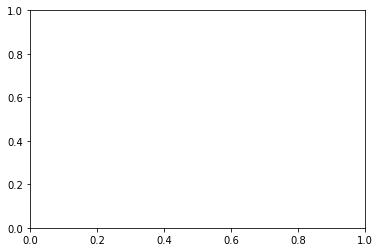

In [16]:
import matplotlib.pyplot as plt
plt.plot(x,y)

In [25]:
6400 * 6400 * 4 / 1000000

163.84

In [51]:
from functools import partial
from jax import grad, jit
import jax.numpy as jnp
import numpy as np
import resource

class F:
    def __init__(self):
        self.A = np.ones((1000000, 100))
        self.A = jnp.asarray(self.A)
        self._gr = jit(grad(self._fn))
    @partial(jit, static_argnums=(0,))
    def _fn(self, x, A):
        y = jnp.dot(A, x)
        return jnp.sum(y)
    def fn(self, x):
        return self._fn(x, self.A)
    def gr(self, x):
        return self._gr(x, self.A)

rss_mb = lambda: resource.getrusage(resource.RUSAGE_SELF).ru_maxrss/1024
init = rss_mb()

objF = F()
x = np.ones(100)
x = jnp.asarray(x)
y = objF.fn(x).block_until_ready()

print("Before grad")
print(f"RSS: {rss_mb() - init:.2f}MB")

z = objF.gr(x).block_until_ready()

print("After grad")
print(f"RSS: {rss_mb() - init:.2f}MB")

Before grad
RSS: 1532.27MB
After grad
RSS: 1532.27MB


In [4]:
import jax
import jax.numpy as jnp
import jax.profiler

def func1(x):
  return jnp.tile(x, 10) * 0.5

def func2(x):
  y = func1(x)
  return y, jnp.tile(x, 10) + 1

x = jax.random.normal(jax.random.PRNGKey(42), (10000, 1000))
y, z = func2(x)

z.block_until_ready()

jax.profiler.save_device_memory_profile("memory.prof")


In [13]:

result = pmap(lambda x: x ** 2)(jnp.arange(7))
print(result)


[ 0  1  4  9 16 25 36]


In [176]:
def delete_variables(): 
    for name in dir():
        if not name.startswith('_'):
            del globals()[name]

Main binary filename not available.
Generating report in profile001.png


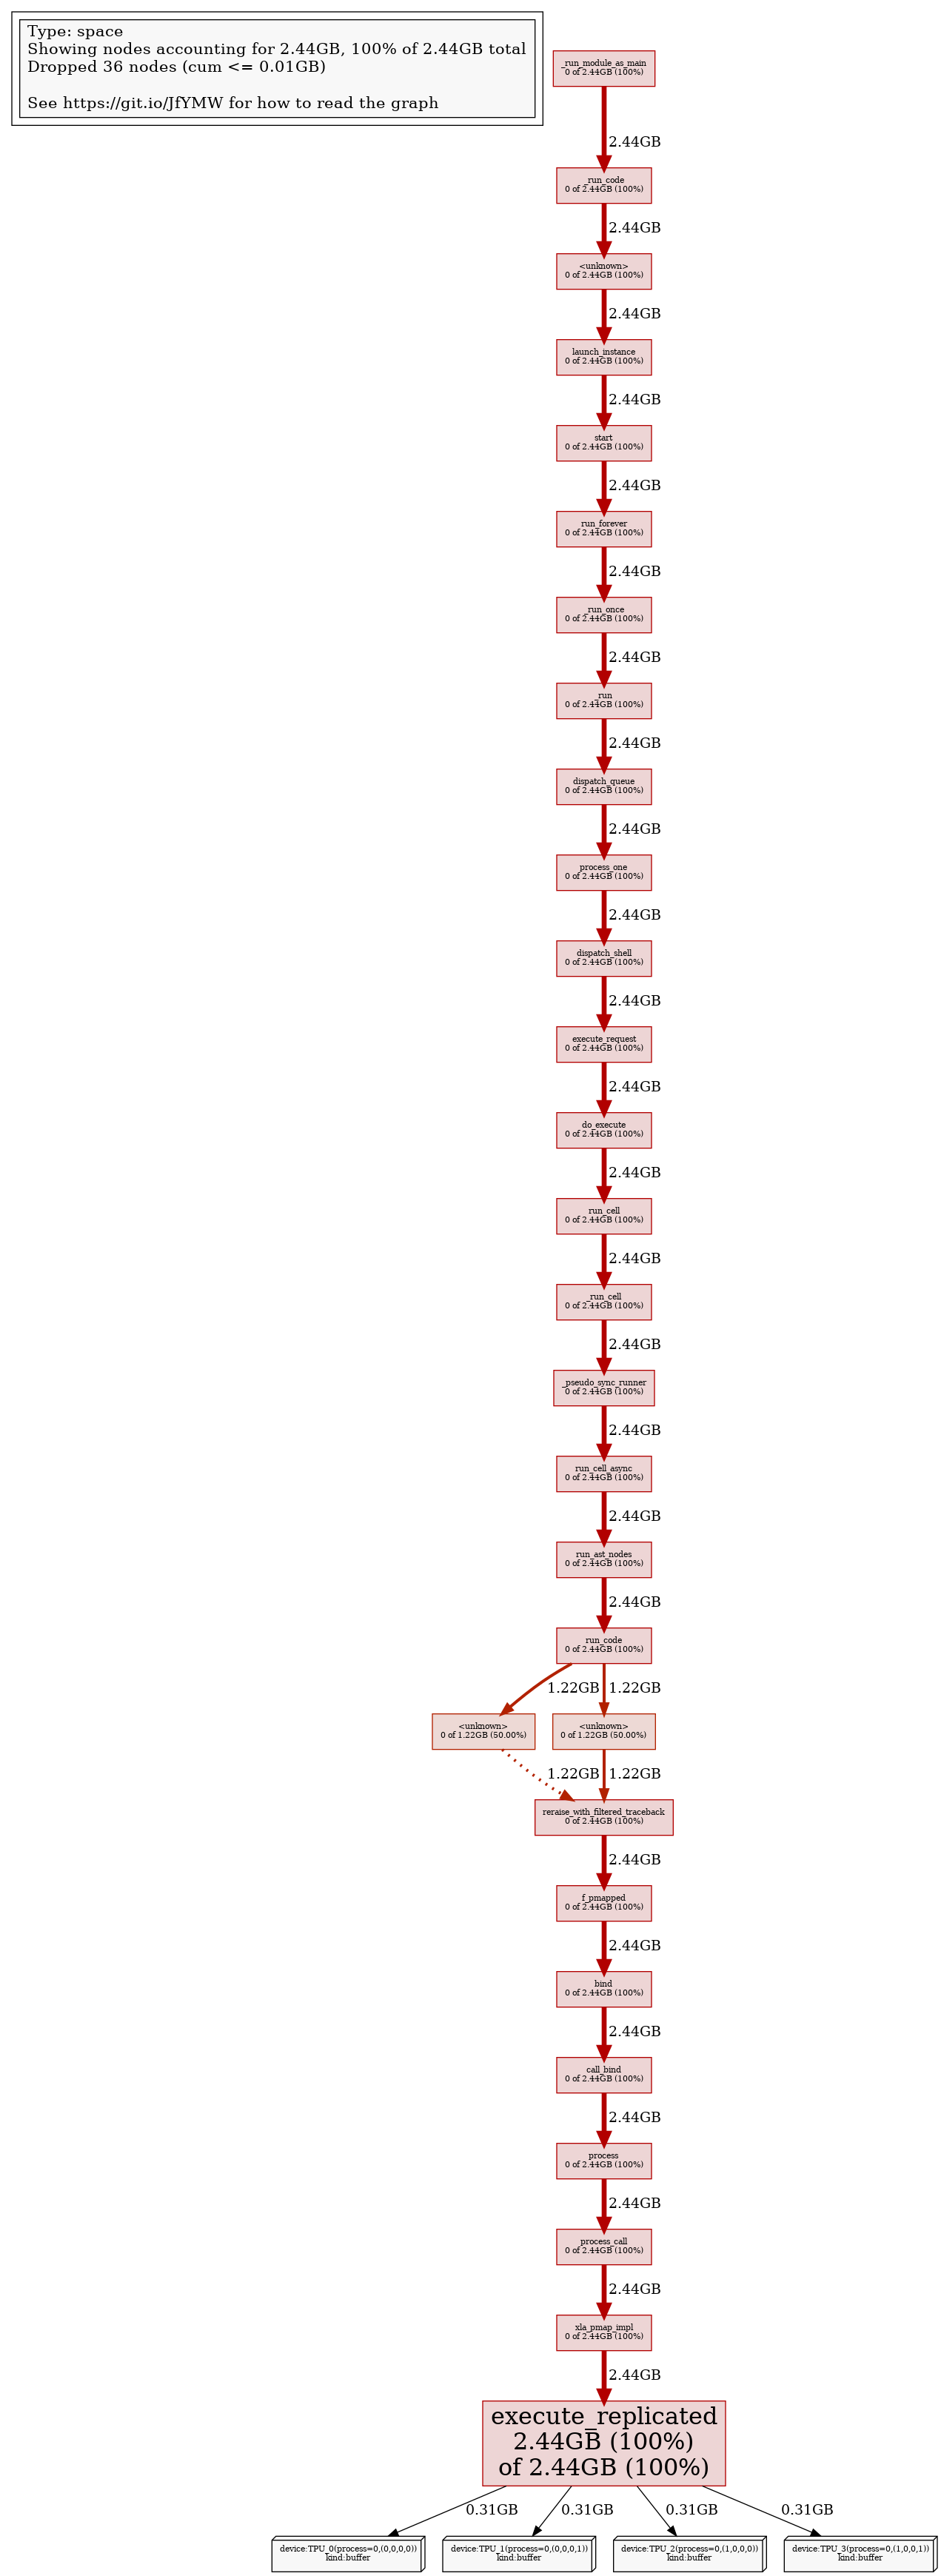

In [14]:
# Run with a bunch of CPU devices.
def setUpModule():
    global prev_xla_flags
    prev_xla_flags = os.getenv("XLA_FLAGS")
    flags_str = prev_xla_flags or ""
    if "xla_force_host_platform_device_count" not in flags_str:
        os.environ["XLA_FLAGS"] = (flags_str + " --xla_force_host_platform_device_count=16")

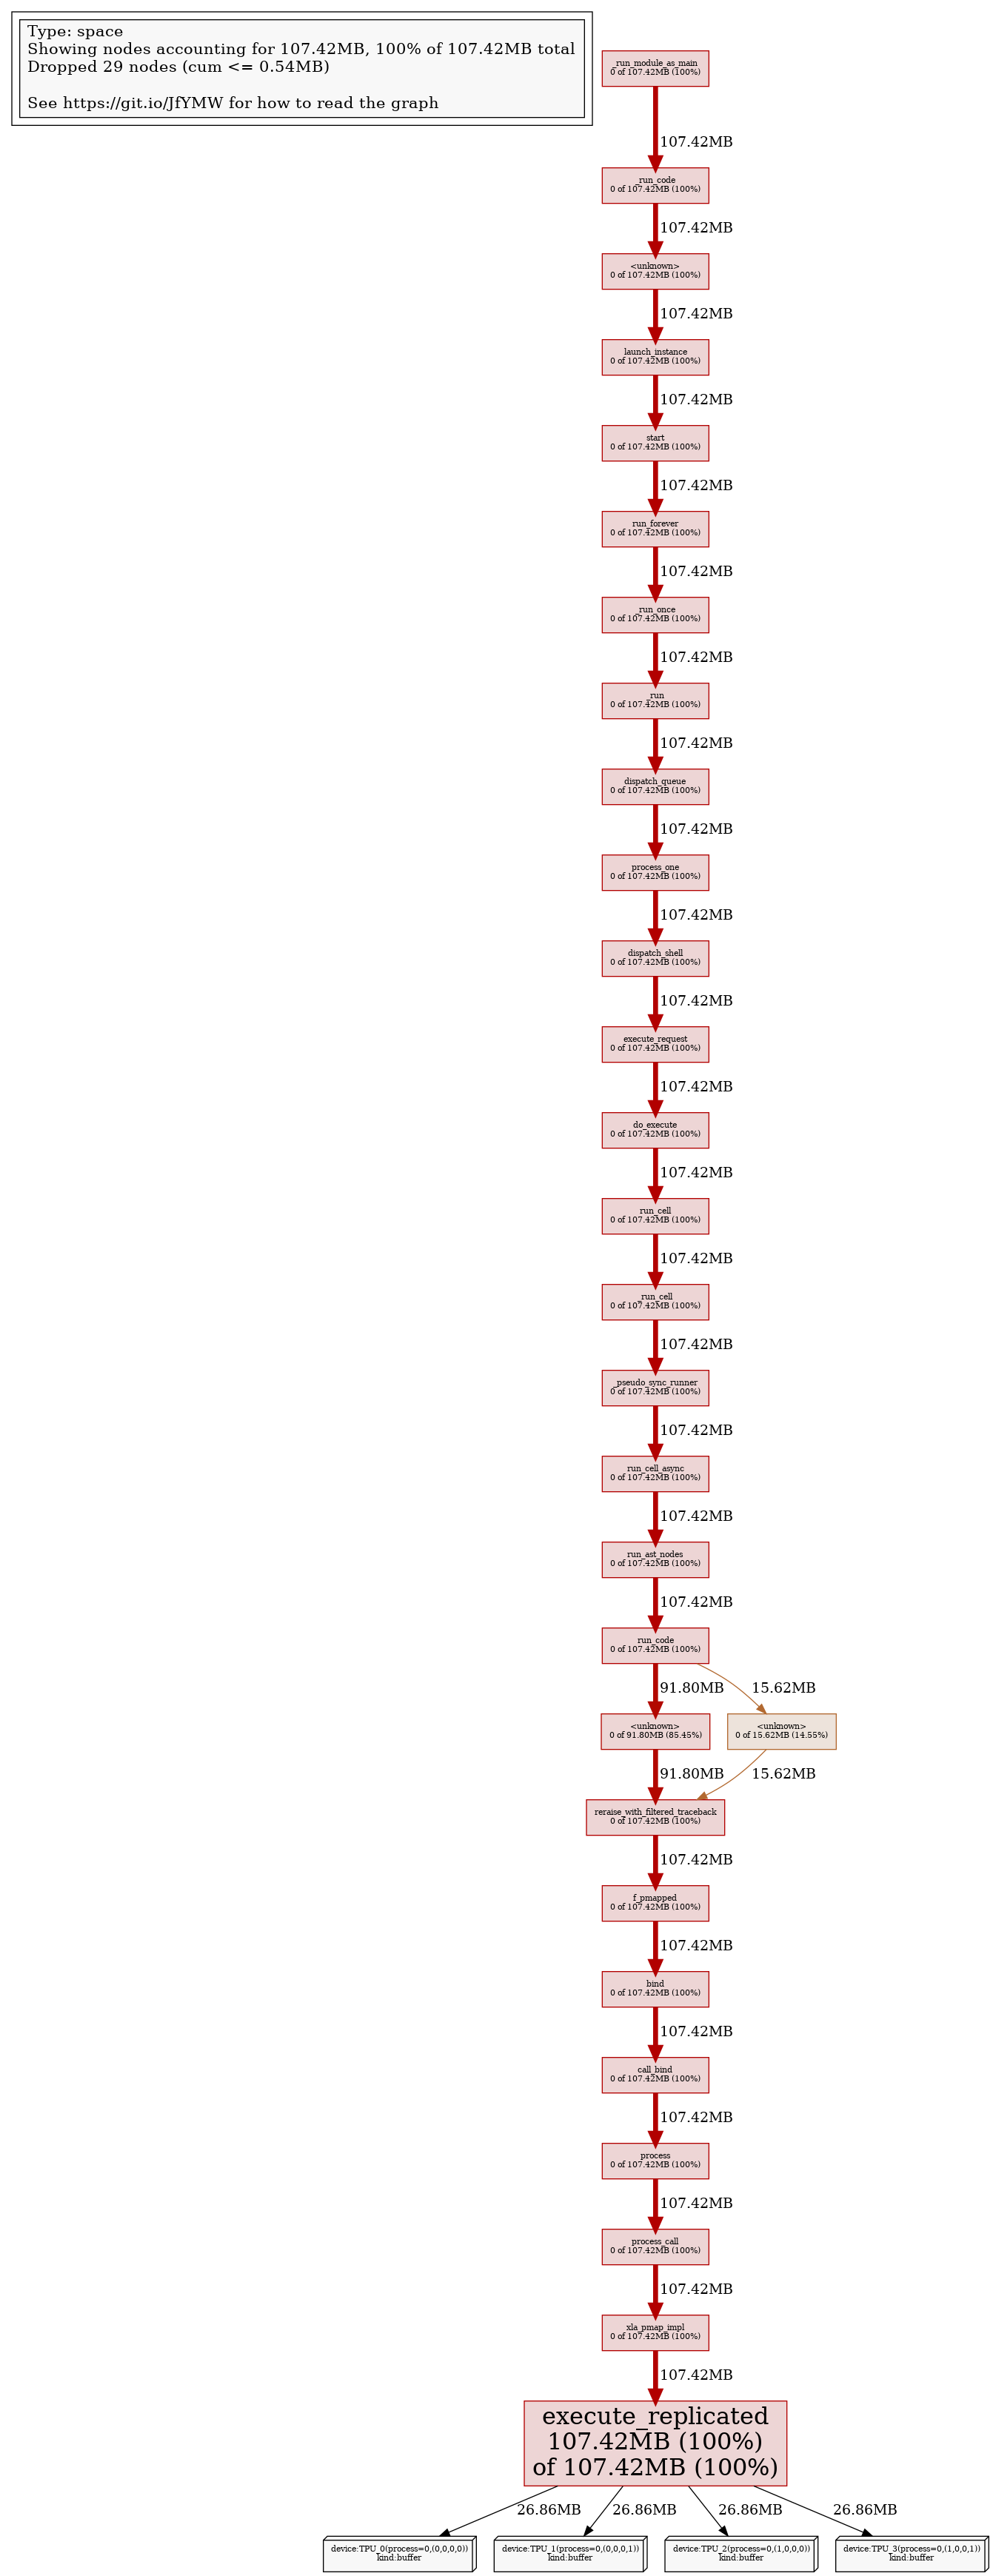